In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from autogenes import AutoGenes

from sklearn.svm import NuSVR

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Reading inputs

In [2]:
#read single cell data from https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-1033-x
file = 'data/GSE75748_sc_cell_type_ec.csv'
adata = sc.read(file, cache=True).transpose()
adata

AnnData object with n_obs × n_vars = 1018 × 19097 

In [6]:
#read 100 synthetic bulks generated by summing single cells
path = './bulks/'
adata_bulk_raw = sc.read(path + 'adata_mean_orig.h5ad', cache=True)
sc.pp.normalize_per_cell(adata_bulk_raw, counts_per_cell_after=1e4)
proportions = pd.read_csv(path + "proportions.txt", sep=' ', index_col=0)

# Preprocessing single-cell data

In [7]:
#normalizing and selecting 4000 hihgly variable genes for optimization
adata_norm = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True) #1
adata_log = sc.pp.log1p(adata_norm, copy=True) # we use log data only for visualization
sc.pp.highly_variable_genes(adata_log, flavor='cell_ranger', n_top_genes=4000)
adata_proc = adata_norm[:, adata_log.var[adata_log.var['highly_variable']==True].index]

In [8]:
adata_proc

View of AnnData object with n_obs × n_vars = 1018 × 4000 
    obs: 'n_counts'

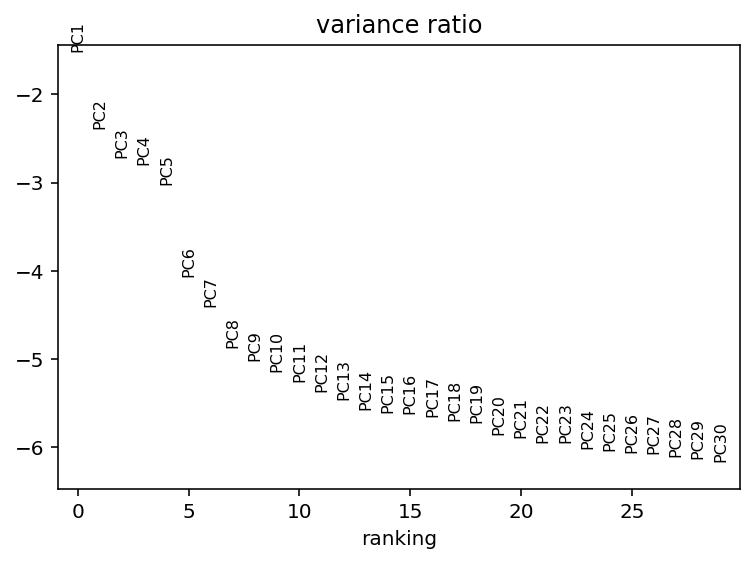

In [10]:
sc.pp.pca(adata_log, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_log, log=True)

In [11]:
adata_log.obs['cells'] = [x.split('_', 1)[0] for x in adata_log.obs_names]

... storing 'cells' as categorical


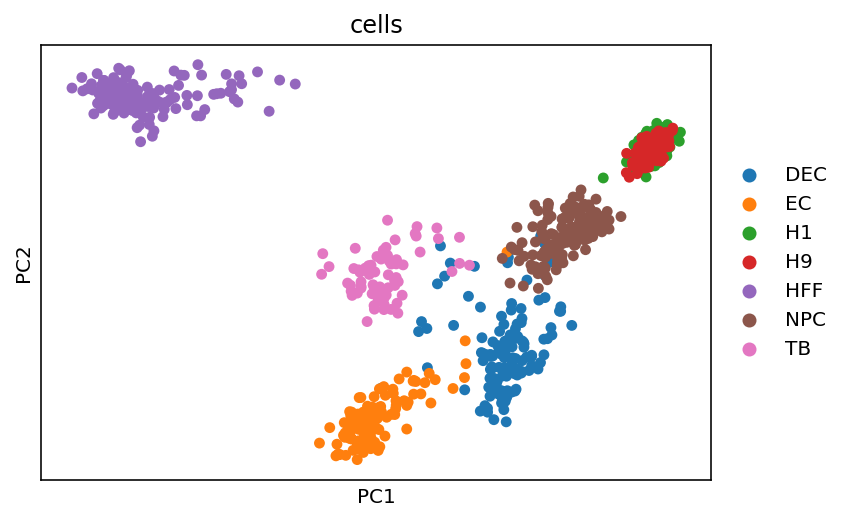

In [12]:
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata_log, color='cells')

In [13]:
#remove H9 because of high correlation with H1
adata_log = adata_log[adata_log.obs[adata_log.obs['cells'] != 'H9'].index]

In [14]:
#filter cells in normalized data
adata_proc = adata_proc[adata_log.obs_names]

In [15]:
#centroids of cell types
clusters = np.array(['H1', 'DEC', 'EC', 'HFF', 'NPC', 'TB'])
sc_mean = pd.DataFrame(index=adata_proc.var_names,columns=clusters)
for cluster in clusters:
    cells = [x for x in adata_proc.obs_names if x.startswith(cluster)]
    sc_part = adata_proc[cells,:].X.T
    sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)
    
centroids_sc_hv = sc_mean

In [16]:
centroids_sc_hv.shape

(4000, 6)

# AutoGeneS

In [18]:
ag = AutoGenes(centroids_sc_hv.T)
ag.run(ngen=5000,seed=0,nfeatures=400,mode='fixed')

gen	nevals	pareto	distance       	correlation 
0  	100   	5     	309.15 - 1219.8	2.01 - 14.75
1  	100   	7     	407.67 - 1219.85	1.8 - 14.53 
2  	100   	3     	610.88 - 1219.95	1.79 - 14.17
3  	100   	4     	629.18 - 1219.95	1.79 - 13.46
4  	100   	4     	661.32 - 1220.27	1.79 - 13.38
5  	100   	4     	661.32 - 1225.94	1.79 - 13.38
6  	100   	5     	711.26 - 1225.99	1.79 - 13.38
7  	100   	8     	711.26 - 1226.34	1.38 - 13.38
8  	100   	9     	711.26 - 1226.34	1.38 - 13.38
9  	100   	8     	711.26 - 1226.53	1.38 - 13.38
10 	100   	10    	711.25 - 1232.0 	1.38 - 13.37
11 	100   	8     	711.25 - 1237.71	1.38 - 13.37
12 	100   	8     	711.08 - 1329.32	1.38 - 13.36
13 	100   	9     	711.08 - 1329.32	1.31 - 13.36
14 	100   	11    	908.52 - 1329.32	1.31 - 13.36
15 	100   	9     	909.75 - 1329.32	1.31 - 13.36
16 	100   	9     	911.68 - 1329.32	1.31 - 13.36
17 	100   	10    	911.68 - 1329.42	1.31 - 13.36
18 	100   	13    	911.68 - 1329.42	1.31 - 13.35
19 	100   	14    	911.68 - 1344.72	1.31 - 

170	100   	46    	980.0 - 1570.45 	0.73 - 12.33
171	100   	46    	980.0 - 1570.45 	0.73 - 12.33
172	100   	46    	980.0 - 1570.45 	0.73 - 12.33
173	100   	47    	979.9 - 1570.45 	0.73 - 12.33
174	100   	47    	979.9 - 1570.45 	0.73 - 12.31
175	100   	52    	980.33 - 1570.45	0.73 - 12.31
176	100   	50    	980.33 - 1570.45	0.73 - 12.31
177	100   	48    	980.33 - 1570.45	0.73 - 12.31
178	100   	49    	980.33 - 1570.45	0.73 - 12.31
179	100   	51    	980.33 - 1570.45	0.73 - 12.31
180	100   	45    	980.33 - 1570.45	0.73 - 12.31
181	100   	47    	980.33 - 1570.45	0.73 - 12.31
182	100   	51    	980.33 - 1570.45	0.73 - 12.31
183	100   	47    	980.33 - 1570.45	0.73 - 12.31
184	100   	48    	980.33 - 1570.45	0.73 - 12.31
185	100   	50    	980.33 - 1570.45	0.73 - 12.31
186	100   	49    	980.43 - 1570.65	0.72 - 12.31
187	100   	48    	980.43 - 1570.72	0.72 - 12.31
188	100   	50    	980.43 - 1570.72	0.72 - 12.31
189	100   	54    	980.43 - 1570.72	0.72 - 12.31
190	100   	49    	975.1 - 1570.72 	0.72 

342	100   	61    	961.49 - 1702.24	0.58 - 11.73
343	100   	67    	961.49 - 1702.24	0.58 - 11.73
344	100   	71    	961.6 - 1702.24 	0.58 - 11.73
345	100   	69    	961.6 - 1702.24 	0.58 - 11.73
346	100   	67    	961.6 - 1702.24 	0.58 - 11.73
347	100   	63    	961.6 - 1702.24 	0.58 - 11.73
348	100   	70    	961.6 - 1702.24 	0.58 - 11.73
349	100   	70    	961.6 - 1702.24 	0.58 - 11.73
350	100   	71    	961.6 - 1702.24 	0.58 - 11.73
351	100   	68    	961.6 - 1702.24 	0.58 - 11.73
352	100   	73    	961.6 - 1702.24 	0.58 - 11.73
353	100   	69    	961.6 - 1702.24 	0.58 - 11.73
354	100   	74    	961.6 - 1702.24 	0.58 - 11.73
355	100   	79    	961.69 - 1702.24	0.58 - 11.73
356	100   	81    	961.69 - 1702.24	0.58 - 11.73
357	100   	84    	961.69 - 1702.24	0.58 - 11.73
358	100   	83    	961.69 - 1702.24	0.58 - 11.73
359	100   	77    	961.68 - 1702.24	0.58 - 11.73
360	100   	78    	960.34 - 1702.24	0.58 - 11.73
361	100   	74    	960.34 - 1702.48	0.58 - 11.73
362	100   	72    	960.34 - 1703.09	0.58 

513	100   	86    	969.32 - 1736.5 	0.5 - 11.62 
514	100   	92    	969.32 - 1736.5 	0.5 - 11.62 
515	100   	97    	969.32 - 1736.5 	0.5 - 11.62 
516	100   	99    	969.32 - 1752.66	0.5 - 11.5  
517	100   	100   	969.32 - 1752.66	0.5 - 11.5  
518	100   	99    	969.32 - 1752.66	0.5 - 11.5  
519	100   	95    	969.32 - 1752.66	0.5 - 11.5  
520	100   	97    	969.32 - 1752.66	0.5 - 11.5  
521	100   	95    	969.32 - 1752.66	0.5 - 11.5  
522	100   	88    	969.32 - 1758.66	0.5 - 11.5  
523	100   	93    	969.32 - 1758.66	0.5 - 11.48 
524	100   	94    	969.32 - 1758.66	0.5 - 11.48 
525	100   	97    	969.32 - 1758.66	0.5 - 11.48 
526	100   	98    	969.32 - 1758.66	0.5 - 11.48 
527	100   	105   	969.32 - 1758.66	0.5 - 11.48 
528	100   	107   	969.32 - 1758.66	0.5 - 11.48 
529	100   	101   	969.32 - 1758.66	0.5 - 11.48 
530	100   	100   	969.32 - 1758.66	0.5 - 11.48 
531	100   	104   	969.32 - 1758.66	0.5 - 11.48 
532	100   	102   	969.32 - 1758.66	0.5 - 11.48 
533	100   	102   	969.32 - 1758.66	0.5 -

685	100   	93    	862.58 - 1765.8 	0.36 - 11.45
686	100   	94    	862.59 - 1765.8 	0.36 - 11.45
687	100   	100   	862.59 - 1765.8 	0.36 - 11.45
688	100   	100   	862.59 - 1765.8 	0.36 - 11.45
689	100   	97    	862.59 - 1765.8 	0.36 - 11.45
690	100   	94    	862.59 - 1765.8 	0.36 - 11.45
691	100   	103   	862.59 - 1765.8 	0.36 - 11.45
692	100   	105   	862.59 - 1765.8 	0.36 - 11.45
693	100   	108   	862.59 - 1765.8 	0.36 - 11.45
694	100   	108   	862.59 - 1765.8 	0.36 - 11.45
695	100   	110   	862.59 - 1765.8 	0.36 - 11.45
696	100   	108   	862.59 - 1765.8 	0.36 - 11.45
697	100   	107   	862.59 - 1765.8 	0.36 - 11.45
698	100   	99    	862.25 - 1765.8 	0.36 - 11.45
699	100   	99    	862.59 - 1765.8 	0.36 - 11.45
700	100   	99    	862.59 - 1765.8 	0.36 - 11.45
701	100   	101   	862.59 - 1765.8 	0.36 - 11.45
702	100   	98    	862.59 - 1765.81	0.36 - 11.45
703	100   	97    	862.59 - 1776.07	0.36 - 11.45
704	100   	101   	862.59 - 1776.07	0.36 - 11.42
705	100   	101   	862.59 - 1776.07	0.36 

857	100   	108   	956.85 - 1804.0 	0.34 - 11.22
858	100   	108   	956.85 - 1804.0 	0.34 - 11.22
859	100   	109   	956.85 - 1804.0 	0.34 - 11.22
860	100   	111   	956.85 - 1804.0 	0.34 - 11.22
861	100   	116   	956.85 - 1804.0 	0.34 - 11.22
862	100   	111   	956.85 - 1804.0 	0.34 - 11.22
863	100   	108   	956.55 - 1804.0 	0.34 - 11.22
864	100   	108   	956.55 - 1804.28	0.34 - 11.22
865	100   	110   	956.55 - 1804.28	0.34 - 11.22
866	100   	111   	956.55 - 1804.28	0.34 - 11.22
867	100   	117   	956.55 - 1804.28	0.34 - 11.22
868	100   	123   	956.55 - 1804.28	0.34 - 11.22
869	100   	123   	956.55 - 1804.28	0.34 - 11.22
870	100   	124   	956.55 - 1804.28	0.34 - 11.22
871	100   	114   	956.55 - 1804.28	0.34 - 11.22
872	100   	113   	956.55 - 1804.34	0.34 - 11.22
873	100   	112   	956.55 - 1804.34	0.34 - 11.22
874	100   	116   	956.55 - 1804.34	0.34 - 11.22
875	100   	111   	956.55 - 1804.34	0.34 - 11.22
876	100   	115   	956.97 - 1804.34	0.34 - 11.22
877	100   	109   	956.97 - 1804.34	0.34 

1028	100   	143   	970.76 - 1806.99	0.31 - 11.21
1029	100   	145   	964.7 - 1806.99 	0.3 - 11.21 
1030	100   	150   	964.7 - 1806.99 	0.3 - 11.21 
1031	100   	152   	964.7 - 1806.99 	0.3 - 11.21 
1032	100   	148   	964.7 - 1806.99 	0.3 - 11.21 
1033	100   	146   	964.7 - 1807.03 	0.3 - 11.21 
1034	100   	150   	964.7 - 1807.03 	0.3 - 11.21 
1035	100   	152   	964.7 - 1807.03 	0.3 - 11.21 
1036	100   	154   	964.7 - 1807.29 	0.3 - 11.2  
1037	100   	150   	964.7 - 1807.29 	0.3 - 11.2  
1038	100   	154   	964.7 - 1807.29 	0.3 - 11.2  
1039	100   	155   	964.7 - 1807.29 	0.3 - 11.2  
1040	100   	151   	964.7 - 1807.29 	0.3 - 11.2  
1041	100   	150   	964.7 - 1807.29 	0.3 - 11.2  
1042	100   	149   	964.7 - 1807.29 	0.3 - 11.2  
1043	100   	144   	964.7 - 1807.29 	0.3 - 11.2  
1044	100   	144   	964.7 - 1807.29 	0.3 - 11.2  
1045	100   	140   	964.7 - 1807.29 	0.3 - 11.2  
1046	100   	138   	964.68 - 1807.29	0.3 - 11.2  
1047	100   	138   	964.68 - 1807.29	0.3 - 11.2  
1048	100   	133   	9

1196	100   	161   	965.43 - 1809.41	0.29 - 11.19
1197	100   	164   	965.43 - 1809.41	0.29 - 11.19
1198	100   	162   	965.43 - 1809.41	0.29 - 11.19
1199	100   	167   	965.43 - 1809.41	0.29 - 11.19
1200	100   	169   	965.43 - 1809.41	0.29 - 11.19
1201	100   	169   	965.43 - 1809.41	0.29 - 11.19
1202	100   	172   	965.43 - 1809.41	0.29 - 11.19
1203	100   	176   	965.43 - 1809.41	0.29 - 11.19
1204	100   	176   	965.43 - 1809.41	0.29 - 11.19
1205	100   	184   	965.43 - 1809.41	0.29 - 11.19
1206	100   	186   	965.43 - 1809.41	0.29 - 11.19
1207	100   	189   	965.43 - 1809.41	0.29 - 11.19
1208	100   	187   	965.43 - 1809.41	0.29 - 11.19
1209	100   	182   	965.43 - 1809.41	0.29 - 11.19
1210	100   	180   	965.43 - 1809.41	0.29 - 11.19
1211	100   	183   	934.99 - 1809.41	0.28 - 11.19
1212	100   	182   	934.99 - 1809.41	0.28 - 11.19
1213	100   	183   	934.99 - 1809.41	0.28 - 11.19
1214	100   	180   	934.99 - 1809.41	0.28 - 11.19
1215	100   	184   	934.99 - 1809.41	0.28 - 11.19
1216	100   	185   	9

1365	100   	210   	945.34 - 1878.49	0.24 - 10.61
1366	100   	211   	945.34 - 1878.49	0.24 - 10.61
1367	100   	204   	945.34 - 1878.49	0.24 - 10.61
1368	100   	204   	945.34 - 1878.49	0.24 - 10.61
1369	100   	206   	945.34 - 1878.49	0.24 - 10.61
1370	100   	210   	945.34 - 1878.49	0.24 - 10.61
1371	100   	207   	945.34 - 1878.49	0.24 - 10.61
1372	100   	205   	945.34 - 1878.49	0.24 - 10.61
1373	100   	207   	945.34 - 1878.49	0.24 - 10.61
1374	100   	205   	945.34 - 1878.49	0.24 - 10.61
1375	100   	206   	945.34 - 1878.71	0.24 - 10.61
1376	100   	209   	945.34 - 1878.71	0.24 - 10.61
1377	100   	211   	945.34 - 1878.71	0.24 - 10.61
1378	100   	206   	945.42 - 1879.06	0.24 - 10.61
1379	100   	207   	945.42 - 1879.06	0.24 - 10.61
1380	100   	211   	945.42 - 1879.06	0.24 - 10.61
1381	100   	207   	945.42 - 1879.06	0.24 - 10.61
1382	100   	209   	945.42 - 1879.06	0.24 - 10.61
1383	100   	211   	945.42 - 1879.06	0.24 - 10.61
1384	100   	212   	945.42 - 1879.06	0.24 - 10.61
1385	100   	214   	9

1534	100   	225   	946.6 - 1970.28 	0.22 - 10.44
1535	100   	231   	946.6 - 1970.28 	0.22 - 10.44
1536	100   	233   	946.6 - 1970.28 	0.22 - 10.44
1537	100   	242   	946.11 - 1970.28	0.22 - 10.44
1538	100   	243   	946.11 - 1970.28	0.22 - 10.44
1539	100   	245   	945.63 - 1970.28	0.22 - 10.44
1540	100   	246   	945.63 - 1970.28	0.22 - 10.44
1541	100   	234   	945.63 - 1970.28	0.22 - 10.44
1542	100   	236   	945.63 - 1970.28	0.22 - 10.44
1543	100   	229   	945.63 - 1970.28	0.22 - 10.44
1544	100   	232   	945.63 - 1970.28	0.22 - 10.44
1545	100   	235   	945.63 - 1970.28	0.22 - 10.44
1546	100   	237   	945.63 - 1970.28	0.22 - 10.44
1547	100   	233   	945.63 - 1970.28	0.22 - 10.44
1548	100   	234   	945.63 - 1970.28	0.22 - 10.44
1549	100   	238   	945.63 - 1970.28	0.22 - 10.44
1550	100   	243   	945.63 - 1970.28	0.22 - 10.44
1551	100   	237   	945.63 - 1970.28	0.22 - 10.44
1552	100   	238   	945.59 - 1970.28	0.22 - 10.44
1553	100   	240   	945.59 - 1970.28	0.22 - 10.44
1554	100   	240   	9

1703	100   	218   	940.74 - 1981.3 	0.21 - 10.4 
1704	100   	221   	940.74 - 1981.3 	0.21 - 10.4 
1705	100   	220   	940.74 - 1981.3 	0.21 - 10.4 
1706	100   	221   	940.74 - 1981.3 	0.21 - 10.4 
1707	100   	224   	940.74 - 1981.3 	0.21 - 10.4 
1708	100   	227   	940.74 - 1981.3 	0.21 - 10.4 
1709	100   	225   	940.74 - 1981.3 	0.21 - 10.4 
1710	100   	225   	940.74 - 1981.3 	0.21 - 10.4 
1711	100   	228   	940.74 - 1981.3 	0.21 - 10.4 
1712	100   	230   	940.74 - 1981.3 	0.21 - 10.4 
1713	100   	225   	940.74 - 1981.3 	0.21 - 10.4 
1714	100   	228   	940.74 - 1981.94	0.21 - 10.4 
1715	100   	230   	940.74 - 1981.94	0.21 - 10.4 
1716	100   	232   	940.74 - 1981.94	0.21 - 10.4 
1717	100   	234   	940.74 - 1981.94	0.21 - 10.4 
1718	100   	232   	940.74 - 1981.94	0.21 - 10.4 
1719	100   	227   	940.74 - 1981.94	0.21 - 10.4 
1720	100   	231   	940.74 - 1981.94	0.21 - 10.4 
1721	100   	234   	940.74 - 1981.94	0.21 - 10.4 
1722	100   	235   	940.74 - 1981.94	0.21 - 10.4 
1723	100   	240   	9

1872	100   	243   	939.61 - 1989.08	0.19 - 10.37
1873	100   	245   	939.61 - 1989.08	0.19 - 10.37
1874	100   	248   	939.61 - 1989.1 	0.19 - 10.37
1875	100   	250   	939.61 - 1989.1 	0.19 - 10.37
1876	100   	252   	939.61 - 1989.1 	0.19 - 10.37
1877	100   	255   	939.61 - 1989.1 	0.19 - 10.37
1878	100   	254   	939.6 - 1989.1  	0.19 - 10.37
1879	100   	250   	939.6 - 1989.1  	0.19 - 10.37
1880	100   	254   	939.6 - 1989.1  	0.19 - 10.37
1881	100   	252   	939.6 - 1989.1  	0.19 - 10.37
1882	100   	249   	939.6 - 1989.1  	0.19 - 10.37
1883	100   	253   	939.6 - 1989.1  	0.19 - 10.37
1884	100   	249   	939.6 - 1989.1  	0.19 - 10.37
1885	100   	255   	939.6 - 1989.1  	0.19 - 10.37
1886	100   	262   	939.6 - 1989.1  	0.19 - 10.37
1887	100   	258   	939.6 - 1989.1  	0.19 - 10.37
1888	100   	259   	939.6 - 1989.1  	0.19 - 10.37
1889	100   	259   	939.6 - 1989.1  	0.19 - 10.37
1890	100   	257   	939.6 - 1989.1  	0.19 - 10.37
1891	100   	262   	939.6 - 1989.1  	0.19 - 10.37
1892	100   	256   	9

2040	100   	280   	939.38 - 2006.5 	0.19 - 10.31
2041	100   	279   	939.38 - 2006.5 	0.19 - 10.31
2042	100   	282   	939.38 - 2006.5 	0.19 - 10.31
2043	100   	282   	939.38 - 2006.5 	0.19 - 10.31
2044	100   	277   	939.38 - 2006.5 	0.19 - 10.31
2045	100   	268   	939.38 - 2006.5 	0.19 - 10.31
2046	100   	266   	939.38 - 2006.5 	0.19 - 10.31
2047	100   	261   	939.38 - 2006.5 	0.19 - 10.31
2048	100   	260   	939.38 - 2006.5 	0.19 - 10.31
2049	100   	263   	939.38 - 2006.5 	0.19 - 10.31
2050	100   	254   	939.94 - 2006.5 	0.19 - 10.31
2051	100   	255   	939.94 - 2006.5 	0.19 - 10.31
2052	100   	257   	939.94 - 2006.76	0.19 - 10.31
2053	100   	262   	939.94 - 2006.76	0.19 - 10.31
2054	100   	268   	940.06 - 2006.76	0.19 - 10.31
2055	100   	259   	940.06 - 2006.76	0.19 - 10.31
2056	100   	258   	940.06 - 2006.76	0.19 - 10.31
2057	100   	259   	940.06 - 2006.76	0.19 - 10.31
2058	100   	261   	940.06 - 2006.76	0.19 - 10.31
2059	100   	261   	940.06 - 2006.76	0.19 - 10.31
2060	100   	262   	9

2209	100   	306   	940.83 - 2007.49	0.18 - 10.3 
2210	100   	308   	940.83 - 2007.49	0.18 - 10.3 
2211	100   	301   	940.83 - 2007.49	0.18 - 10.3 
2212	100   	303   	940.83 - 2007.49	0.18 - 10.3 
2213	100   	298   	940.83 - 2007.49	0.18 - 10.3 
2214	100   	300   	940.76 - 2007.49	0.18 - 10.3 
2215	100   	298   	940.76 - 2007.49	0.18 - 10.3 
2216	100   	296   	940.76 - 2007.49	0.18 - 10.3 
2217	100   	299   	940.76 - 2007.49	0.18 - 10.3 
2218	100   	299   	940.76 - 2007.49	0.18 - 10.3 
2219	100   	296   	940.76 - 2007.49	0.18 - 10.3 
2220	100   	300   	940.76 - 2007.49	0.18 - 10.3 
2221	100   	301   	940.76 - 2007.49	0.18 - 10.3 
2222	100   	302   	940.76 - 2007.49	0.18 - 10.3 
2223	100   	308   	940.76 - 2007.49	0.18 - 10.3 
2224	100   	308   	940.76 - 2007.49	0.18 - 10.3 
2225	100   	310   	940.76 - 2007.49	0.18 - 10.3 
2226	100   	314   	940.76 - 2007.49	0.18 - 10.3 
2227	100   	308   	940.76 - 2007.49	0.18 - 10.3 
2228	100   	304   	940.76 - 2007.49	0.18 - 10.3 
2229	100   	303   	9

2377	100   	265   	864.13 - 2011.9 	0.17 - 10.27
2378	100   	268   	864.13 - 2011.9 	0.17 - 10.27
2379	100   	262   	864.13 - 2011.9 	0.17 - 10.27
2380	100   	263   	864.13 - 2011.9 	0.17 - 10.27
2381	100   	263   	864.13 - 2011.9 	0.17 - 10.27
2382	100   	263   	864.13 - 2011.9 	0.17 - 10.27
2383	100   	266   	863.43 - 2011.9 	0.16 - 10.27
2384	100   	266   	863.51 - 2011.9 	0.16 - 10.27
2385	100   	254   	863.51 - 2011.9 	0.16 - 10.27
2386	100   	256   	863.51 - 2011.9 	0.16 - 10.27
2387	100   	255   	863.51 - 2011.9 	0.16 - 10.27
2388	100   	259   	863.51 - 2011.9 	0.16 - 10.27
2389	100   	262   	863.51 - 2011.9 	0.16 - 10.27
2390	100   	265   	863.51 - 2011.9 	0.16 - 10.27
2391	100   	264   	863.51 - 2020.34	0.16 - 10.25
2392	100   	266   	863.51 - 2020.34	0.16 - 10.25
2393	100   	267   	863.51 - 2020.34	0.16 - 10.25
2394	100   	273   	863.51 - 2020.34	0.16 - 10.25
2395	100   	275   	863.51 - 2020.34	0.16 - 10.25
2396	100   	269   	863.51 - 2020.34	0.16 - 10.25
2397	100   	264   	8

2547	100   	299   	859.8 - 2022.84 	0.14 - 10.24
2548	100   	296   	859.8 - 2022.84 	0.14 - 10.24
2549	100   	293   	859.8 - 2022.84 	0.14 - 10.24
2550	100   	293   	859.8 - 2022.84 	0.14 - 10.24
2551	100   	296   	859.8 - 2022.84 	0.14 - 10.24
2552	100   	299   	859.8 - 2022.84 	0.14 - 10.24
2553	100   	293   	859.8 - 2022.84 	0.14 - 10.24
2554	100   	281   	859.8 - 2022.84 	0.14 - 10.24
2555	100   	282   	859.8 - 2022.84 	0.14 - 10.24
2556	100   	283   	859.8 - 2022.86 	0.14 - 10.24
2557	100   	283   	859.8 - 2022.86 	0.14 - 10.24
2558	100   	287   	859.8 - 2022.86 	0.14 - 10.24
2559	100   	289   	859.8 - 2022.86 	0.14 - 10.24
2560	100   	295   	859.8 - 2022.86 	0.14 - 10.24
2561	100   	300   	859.8 - 2022.86 	0.14 - 10.24
2562	100   	299   	859.8 - 2022.86 	0.14 - 10.24
2563	100   	296   	859.8 - 2022.86 	0.14 - 10.24
2564	100   	298   	859.8 - 2022.86 	0.14 - 10.24
2565	100   	297   	859.8 - 2022.86 	0.14 - 10.24
2566	100   	300   	859.8 - 2022.86 	0.14 - 10.24
2567	100   	293   	8

2716	100   	328   	858.7 - 2025.06 	0.13 - 10.23
2717	100   	330   	858.7 - 2025.06 	0.13 - 10.23
2718	100   	324   	858.7 - 2025.06 	0.13 - 10.23
2719	100   	320   	858.7 - 2025.06 	0.13 - 10.23
2720	100   	319   	858.7 - 2025.06 	0.13 - 10.23
2721	100   	319   	858.7 - 2025.06 	0.13 - 10.23
2722	100   	320   	858.7 - 2025.06 	0.13 - 10.23
2723	100   	322   	858.7 - 2025.06 	0.13 - 10.23
2724	100   	323   	858.7 - 2025.06 	0.13 - 10.23
2725	100   	321   	858.7 - 2025.06 	0.13 - 10.23
2726	100   	320   	858.7 - 2025.06 	0.13 - 10.23
2727	100   	309   	858.7 - 2025.06 	0.13 - 10.23
2728	100   	310   	858.7 - 2025.06 	0.13 - 10.23
2729	100   	311   	858.7 - 2025.06 	0.13 - 10.23
2730	100   	312   	858.7 - 2025.06 	0.13 - 10.23
2731	100   	310   	858.7 - 2025.06 	0.13 - 10.23
2732	100   	303   	858.7 - 2025.47 	0.13 - 10.23
2733	100   	304   	858.7 - 2025.47 	0.13 - 10.23
2734	100   	307   	858.7 - 2025.51 	0.13 - 10.23
2735	100   	313   	858.7 - 2025.51 	0.13 - 10.23
2736	100   	310   	8

2884	100   	331   	860.96 - 2027.67	0.13 - 10.21
2885	100   	332   	860.96 - 2027.67	0.13 - 10.21
2886	100   	332   	860.96 - 2027.67	0.13 - 10.21
2887	100   	336   	860.96 - 2027.67	0.13 - 10.21
2888	100   	338   	860.96 - 2027.67	0.13 - 10.21
2889	100   	341   	860.96 - 2027.67	0.13 - 10.21
2890	100   	340   	860.96 - 2027.67	0.13 - 10.21
2891	100   	335   	860.96 - 2027.67	0.13 - 10.21
2892	100   	330   	860.96 - 2027.67	0.13 - 10.21
2893	100   	330   	860.96 - 2027.67	0.13 - 10.21
2894	100   	330   	860.96 - 2027.67	0.13 - 10.21
2895	100   	328   	860.96 - 2027.67	0.13 - 10.21
2896	100   	329   	860.96 - 2027.67	0.13 - 10.21
2897	100   	330   	860.96 - 2027.67	0.13 - 10.21
2898	100   	333   	860.96 - 2027.67	0.13 - 10.21
2899	100   	334   	860.96 - 2027.67	0.13 - 10.21
2900	100   	326   	860.96 - 2027.67	0.13 - 10.21
2901	100   	327   	860.96 - 2027.67	0.13 - 10.21
2902	100   	327   	860.96 - 2027.67	0.13 - 10.21
2903	100   	328   	860.96 - 2027.67	0.13 - 10.21
2904	100   	329   	8

3053	100   	369   	858.13 - 2034.25	0.12 - 10.19
3054	100   	372   	858.13 - 2034.25	0.12 - 10.19
3055	100   	373   	858.13 - 2034.25	0.12 - 10.19
3056	100   	372   	858.13 - 2034.25	0.12 - 10.19
3057	100   	374   	858.13 - 2034.25	0.12 - 10.19
3058	100   	377   	858.13 - 2034.25	0.12 - 10.19
3059	100   	378   	858.13 - 2034.25	0.12 - 10.19
3060	100   	381   	858.13 - 2034.25	0.12 - 10.19
3061	100   	375   	858.13 - 2034.25	0.12 - 10.19
3062	100   	364   	858.13 - 2034.25	0.12 - 10.19
3063	100   	362   	858.13 - 2034.25	0.12 - 10.19
3064	100   	361   	858.13 - 2034.25	0.12 - 10.19
3065	100   	358   	858.13 - 2034.25	0.12 - 10.19
3066	100   	355   	858.13 - 2034.25	0.12 - 10.19
3067	100   	356   	858.13 - 2034.25	0.12 - 10.19
3068	100   	357   	858.13 - 2034.25	0.12 - 10.19
3069	100   	354   	858.13 - 2034.25	0.12 - 10.19
3070	100   	356   	858.13 - 2034.25	0.12 - 10.19
3071	100   	359   	858.13 - 2034.25	0.12 - 10.19
3072	100   	357   	858.13 - 2034.25	0.12 - 10.19
3073	100   	352   	8

3221	100   	352   	858.63 - 2036.63	0.12 - 10.19
3222	100   	350   	858.63 - 2036.84	0.12 - 10.18
3223	100   	350   	858.63 - 2043.75	0.12 - 10.16
3224	100   	349   	858.63 - 2043.75	0.12 - 10.16
3225	100   	344   	858.63 - 2043.75	0.12 - 10.16
3226	100   	346   	858.63 - 2043.75	0.12 - 10.16
3227	100   	346   	858.63 - 2043.75	0.12 - 10.16
3228	100   	341   	858.63 - 2043.75	0.12 - 10.16
3229	100   	338   	852.29 - 2043.75	0.12 - 10.16
3230	100   	337   	852.29 - 2043.75	0.12 - 10.16
3231	100   	338   	852.29 - 2043.75	0.12 - 10.16
3232	100   	341   	852.29 - 2043.75	0.12 - 10.16
3233	100   	342   	852.29 - 2043.75	0.12 - 10.16
3234	100   	343   	852.29 - 2043.75	0.12 - 10.16
3235	100   	344   	852.29 - 2043.75	0.12 - 10.16
3236	100   	344   	852.29 - 2043.75	0.12 - 10.16
3237	100   	346   	852.29 - 2043.75	0.12 - 10.16
3238	100   	350   	852.29 - 2043.75	0.12 - 10.16
3239	100   	348   	852.29 - 2043.75	0.12 - 10.16
3240	100   	334   	852.29 - 2043.75	0.12 - 10.16
3241	100   	333   	8

3389	100   	366   	852.58 - 2051.17	0.11 - 10.14
3390	100   	367   	852.58 - 2051.17	0.11 - 10.14
3391	100   	369   	852.58 - 2051.17	0.11 - 10.14
3392	100   	366   	852.58 - 2051.17	0.11 - 10.14
3393	100   	368   	852.58 - 2051.17	0.11 - 10.14
3394	100   	363   	852.58 - 2051.17	0.11 - 10.14
3395	100   	367   	851.73 - 2053.96	0.11 - 10.14
3396	100   	371   	851.73 - 2053.96	0.11 - 10.14
3397	100   	369   	851.73 - 2053.96	0.11 - 10.14
3398	100   	365   	851.73 - 2053.96	0.11 - 10.14
3399	100   	367   	851.73 - 2053.96	0.11 - 10.14
3400	100   	368   	851.73 - 2053.96	0.11 - 10.14
3401	100   	372   	851.73 - 2053.96	0.11 - 10.14
3402	100   	372   	851.73 - 2053.96	0.11 - 10.14
3403	100   	373   	851.73 - 2053.96	0.11 - 10.14
3404	100   	369   	851.73 - 2053.96	0.11 - 10.14
3405	100   	367   	851.73 - 2053.96	0.11 - 10.14
3406	100   	370   	851.73 - 2053.96	0.11 - 10.14
3407	100   	365   	851.73 - 2054.86	0.11 - 10.13
3408	100   	362   	851.73 - 2054.86	0.11 - 10.13
3409	100   	366   	8

3558	100   	395   	851.53 - 2061.27	0.11 - 10.11
3559	100   	396   	851.53 - 2061.27	0.11 - 10.11
3560	100   	398   	851.53 - 2061.27	0.11 - 10.11
3561	100   	400   	851.53 - 2061.27	0.11 - 10.11
3562	100   	402   	851.53 - 2061.27	0.11 - 10.11
3563	100   	401   	851.53 - 2061.27	0.11 - 10.11
3564	100   	403   	851.53 - 2061.27	0.11 - 10.11
3565	100   	404   	851.53 - 2061.27	0.11 - 10.11
3566	100   	400   	851.53 - 2061.27	0.11 - 10.11
3567	100   	396   	851.53 - 2061.27	0.11 - 10.11
3568	100   	396   	851.53 - 2061.27	0.11 - 10.11
3569	100   	400   	851.53 - 2061.27	0.11 - 10.11
3570	100   	400   	851.53 - 2061.27	0.11 - 10.11
3571	100   	401   	851.53 - 2061.27	0.11 - 10.11
3572	100   	402   	851.53 - 2061.27	0.11 - 10.11
3573	100   	401   	851.53 - 2061.27	0.11 - 10.11
3574	100   	407   	851.53 - 2061.27	0.11 - 10.11
3575	100   	401   	851.53 - 2061.27	0.11 - 10.11
3576	100   	398   	851.53 - 2061.27	0.11 - 10.11
3577	100   	396   	851.53 - 2061.27	0.11 - 10.11
3578	100   	396   	8

3727	100   	396   	852.27 - 2061.75	0.11 - 10.11
3728	100   	394   	852.27 - 2061.75	0.11 - 10.11
3729	100   	380   	852.27 - 2061.75	0.11 - 10.11
3730	100   	374   	852.27 - 2061.75	0.11 - 10.11
3731	100   	373   	852.27 - 2061.75	0.11 - 10.11
3732	100   	374   	852.27 - 2061.75	0.11 - 10.11
3733	100   	374   	852.27 - 2061.75	0.11 - 10.11
3734	100   	373   	852.27 - 2061.75	0.11 - 10.11
3735	100   	371   	852.27 - 2061.75	0.11 - 10.11
3736	100   	371   	852.27 - 2061.75	0.11 - 10.11
3737	100   	374   	852.27 - 2061.75	0.11 - 10.11
3738	100   	379   	852.27 - 2061.76	0.11 - 10.11
3739	100   	385   	852.27 - 2061.76	0.11 - 10.11
3740	100   	387   	852.27 - 2061.76	0.11 - 10.11
3741	100   	387   	852.27 - 2061.76	0.11 - 10.11
3742	100   	382   	852.27 - 2061.76	0.11 - 10.11
3743	100   	383   	852.27 - 2061.76	0.11 - 10.11
3744	100   	379   	852.27 - 2061.76	0.11 - 10.11
3745	100   	380   	852.27 - 2061.76	0.11 - 10.11
3746	100   	378   	852.27 - 2061.76	0.11 - 10.11
3747	100   	378   	8

3895	100   	392   	851.95 - 2073.3 	0.11 - 10.08
3896	100   	396   	851.95 - 2073.3 	0.11 - 10.08
3897	100   	376   	851.95 - 2073.3 	0.11 - 10.08
3898	100   	373   	851.95 - 2073.3 	0.11 - 10.08
3899	100   	369   	851.95 - 2073.3 	0.11 - 10.08
3900	100   	367   	851.95 - 2073.3 	0.11 - 10.08
3901	100   	368   	851.95 - 2073.3 	0.11 - 10.08
3902	100   	368   	851.95 - 2073.3 	0.11 - 10.08
3903	100   	369   	851.95 - 2073.3 	0.11 - 10.08
3904	100   	371   	851.95 - 2073.3 	0.11 - 10.08
3905	100   	373   	851.95 - 2073.3 	0.11 - 10.08
3906	100   	377   	851.95 - 2073.3 	0.11 - 10.08
3907	100   	381   	851.95 - 2073.3 	0.11 - 10.08
3908	100   	383   	851.95 - 2073.3 	0.11 - 10.08
3909	100   	381   	851.95 - 2073.3 	0.11 - 10.08
3910	100   	382   	851.95 - 2073.3 	0.11 - 10.08
3911	100   	384   	851.95 - 2073.3 	0.11 - 10.08
3912	100   	386   	851.95 - 2073.3 	0.11 - 10.08
3913	100   	391   	851.95 - 2073.3 	0.11 - 10.08
3914	100   	390   	851.95 - 2073.3 	0.11 - 10.08
3915	100   	393   	8

4063	100   	375   	851.44 - 2078.63	0.1 - 10.07 
4064	100   	376   	851.44 - 2079.68	0.1 - 10.06 
4065	100   	381   	851.44 - 2079.68	0.1 - 10.06 
4066	100   	379   	851.44 - 2079.68	0.1 - 10.06 
4067	100   	381   	851.44 - 2079.68	0.1 - 10.06 
4068	100   	382   	851.44 - 2079.68	0.1 - 10.06 
4069	100   	383   	851.44 - 2079.68	0.1 - 10.06 
4070	100   	382   	851.44 - 2079.68	0.1 - 10.06 
4071	100   	383   	851.44 - 2079.68	0.1 - 10.06 
4072	100   	387   	851.44 - 2079.68	0.1 - 10.06 
4073	100   	388   	851.44 - 2079.68	0.1 - 10.06 
4074	100   	389   	851.44 - 2079.68	0.1 - 10.06 
4075	100   	391   	851.44 - 2079.68	0.1 - 10.06 
4076	100   	393   	851.44 - 2079.68	0.1 - 10.06 
4077	100   	395   	851.44 - 2079.68	0.1 - 10.06 
4078	100   	397   	851.44 - 2079.68	0.1 - 10.06 
4079	100   	398   	851.44 - 2079.68	0.1 - 10.06 
4080	100   	400   	851.44 - 2079.68	0.1 - 10.06 
4081	100   	399   	851.44 - 2079.69	0.1 - 10.06 
4082	100   	400   	851.44 - 2079.69	0.1 - 10.06 
4083	100   	402   	8

4231	100   	437   	851.47 - 2082.56	0.1 - 10.06 
4232	100   	443   	851.47 - 2082.56	0.1 - 10.06 
4233	100   	443   	851.47 - 2082.56	0.1 - 10.06 
4234	100   	445   	851.47 - 2082.56	0.1 - 10.06 
4235	100   	444   	851.47 - 2082.56	0.1 - 10.06 
4236	100   	444   	851.47 - 2082.56	0.1 - 10.06 
4237	100   	442   	851.47 - 2082.56	0.1 - 10.06 
4238	100   	437   	851.47 - 2082.56	0.1 - 10.06 
4239	100   	436   	851.47 - 2082.56	0.1 - 10.06 
4240	100   	436   	851.47 - 2082.56	0.1 - 10.06 
4241	100   	436   	851.47 - 2082.56	0.1 - 10.06 
4242	100   	437   	851.47 - 2082.56	0.1 - 10.06 
4243	100   	440   	851.47 - 2082.56	0.1 - 10.06 
4244	100   	445   	851.47 - 2082.56	0.1 - 10.06 
4245	100   	450   	851.47 - 2082.56	0.1 - 10.06 
4246	100   	452   	851.47 - 2082.56	0.1 - 10.06 
4247	100   	452   	851.47 - 2082.56	0.1 - 10.06 
4248	100   	456   	851.47 - 2082.56	0.1 - 10.06 
4249	100   	451   	851.47 - 2082.56	0.1 - 10.06 
4250	100   	449   	851.47 - 2082.56	0.1 - 10.06 
4251	100   	456   	8

4399	100   	441   	851.47 - 2085.38	0.1 - 10.05 
4400	100   	443   	851.47 - 2085.38	0.1 - 10.05 
4401	100   	448   	851.47 - 2085.38	0.1 - 10.05 
4402	100   	446   	851.47 - 2085.38	0.1 - 10.05 
4403	100   	452   	851.47 - 2085.5 	0.1 - 10.05 
4404	100   	444   	851.47 - 2085.5 	0.1 - 10.05 
4405	100   	447   	851.47 - 2085.5 	0.1 - 10.05 
4406	100   	449   	851.47 - 2085.5 	0.1 - 10.05 
4407	100   	444   	851.47 - 2087.57	0.1 - 9.99  
4408	100   	445   	851.47 - 2087.57	0.1 - 9.99  
4409	100   	446   	851.47 - 2087.57	0.1 - 9.99  
4410	100   	447   	851.47 - 2087.57	0.1 - 9.99  
4411	100   	443   	851.47 - 2087.57	0.1 - 9.99  
4412	100   	446   	851.47 - 2087.57	0.1 - 9.99  
4413	100   	450   	851.47 - 2087.57	0.1 - 9.99  
4414	100   	441   	851.47 - 2087.57	0.1 - 9.99  
4415	100   	446   	851.47 - 2087.57	0.1 - 9.99  
4416	100   	445   	851.47 - 2087.57	0.1 - 9.99  
4417	100   	447   	851.47 - 2087.57	0.1 - 9.99  
4418	100   	451   	851.47 - 2087.57	0.1 - 9.99  
4419	100   	451   	8

4567	100   	440   	851.48 - 2094.96	0.1 - 9.98  
4568	100   	445   	851.48 - 2094.96	0.1 - 9.98  
4569	100   	445   	851.48 - 2094.96	0.1 - 9.98  
4570	100   	439   	851.48 - 2095.44	0.1 - 9.98  
4571	100   	437   	851.48 - 2095.44	0.1 - 9.98  
4572	100   	442   	851.48 - 2095.44	0.1 - 9.98  
4573	100   	446   	851.48 - 2095.44	0.1 - 9.98  
4574	100   	448   	851.48 - 2095.44	0.1 - 9.98  
4575	100   	449   	851.48 - 2095.44	0.1 - 9.98  
4576	100   	446   	851.48 - 2095.44	0.1 - 9.98  
4577	100   	451   	851.48 - 2095.44	0.1 - 9.98  
4578	100   	456   	851.48 - 2095.44	0.1 - 9.98  
4579	100   	455   	851.48 - 2095.44	0.1 - 9.98  
4580	100   	454   	851.48 - 2095.44	0.1 - 9.98  
4581	100   	456   	851.48 - 2095.44	0.1 - 9.98  
4582	100   	459   	851.48 - 2095.44	0.1 - 9.98  
4583	100   	462   	851.48 - 2095.44	0.1 - 9.98  
4584	100   	463   	851.48 - 2095.44	0.1 - 9.98  
4585	100   	467   	851.48 - 2095.44	0.1 - 9.98  
4586	100   	460   	851.48 - 2095.44	0.1 - 9.98  
4587	100   	462   	8

4736	100   	406   	851.71 - 2097.45	0.1 - 9.98  
4737	100   	407   	851.71 - 2097.45	0.1 - 9.98  
4738	100   	406   	851.71 - 2097.45	0.1 - 9.98  
4739	100   	408   	851.71 - 2097.45	0.1 - 9.98  
4740	100   	410   	851.71 - 2097.45	0.1 - 9.98  
4741	100   	412   	851.71 - 2097.45	0.1 - 9.98  
4742	100   	415   	851.71 - 2097.45	0.1 - 9.98  
4743	100   	419   	851.71 - 2097.45	0.1 - 9.98  
4744	100   	416   	851.71 - 2097.45	0.1 - 9.98  
4745	100   	419   	851.71 - 2097.45	0.1 - 9.98  
4746	100   	418   	851.71 - 2097.45	0.1 - 9.98  
4747	100   	417   	851.71 - 2097.45	0.1 - 9.98  
4748	100   	407   	851.71 - 2097.46	0.1 - 9.98  
4749	100   	407   	851.71 - 2097.46	0.1 - 9.98  
4750	100   	409   	851.71 - 2097.46	0.1 - 9.98  
4751	100   	408   	851.71 - 2097.46	0.1 - 9.98  
4752	100   	404   	851.71 - 2097.46	0.1 - 9.98  
4753	100   	404   	851.71 - 2097.46	0.1 - 9.98  
4754	100   	404   	851.71 - 2097.46	0.1 - 9.98  
4755	100   	403   	851.71 - 2097.46	0.1 - 9.98  
4756	100   	402   	8

4905	100   	392   	851.88 - 2098.54	0.1 - 9.97  
4906	100   	394   	851.88 - 2098.54	0.1 - 9.97  
4907	100   	396   	851.88 - 2098.54	0.1 - 9.97  
4908	100   	396   	851.88 - 2098.54	0.1 - 9.97  
4909	100   	398   	851.88 - 2098.54	0.1 - 9.97  
4910	100   	397   	851.88 - 2098.54	0.1 - 9.97  
4911	100   	391   	851.88 - 2098.54	0.1 - 9.97  
4912	100   	389   	851.88 - 2098.54	0.1 - 9.97  
4913	100   	389   	851.88 - 2098.54	0.1 - 9.97  
4914	100   	387   	851.88 - 2098.54	0.1 - 9.97  
4915	100   	389   	851.88 - 2098.54	0.1 - 9.97  
4916	100   	390   	851.89 - 2098.54	0.1 - 9.97  
4917	100   	383   	851.89 - 2098.54	0.1 - 9.97  
4918	100   	380   	851.89 - 2098.54	0.1 - 9.97  
4919	100   	383   	851.89 - 2098.54	0.1 - 9.97  
4920	100   	385   	851.89 - 2098.54	0.1 - 9.97  
4921	100   	387   	851.89 - 2098.54	0.1 - 9.97  
4922	100   	389   	851.89 - 2098.54	0.1 - 9.97  
4923	100   	391   	851.89 - 2098.54	0.1 - 9.97  
4924	100   	395   	851.89 - 2098.54	0.1 - 9.97  
4925	100   	395   	8

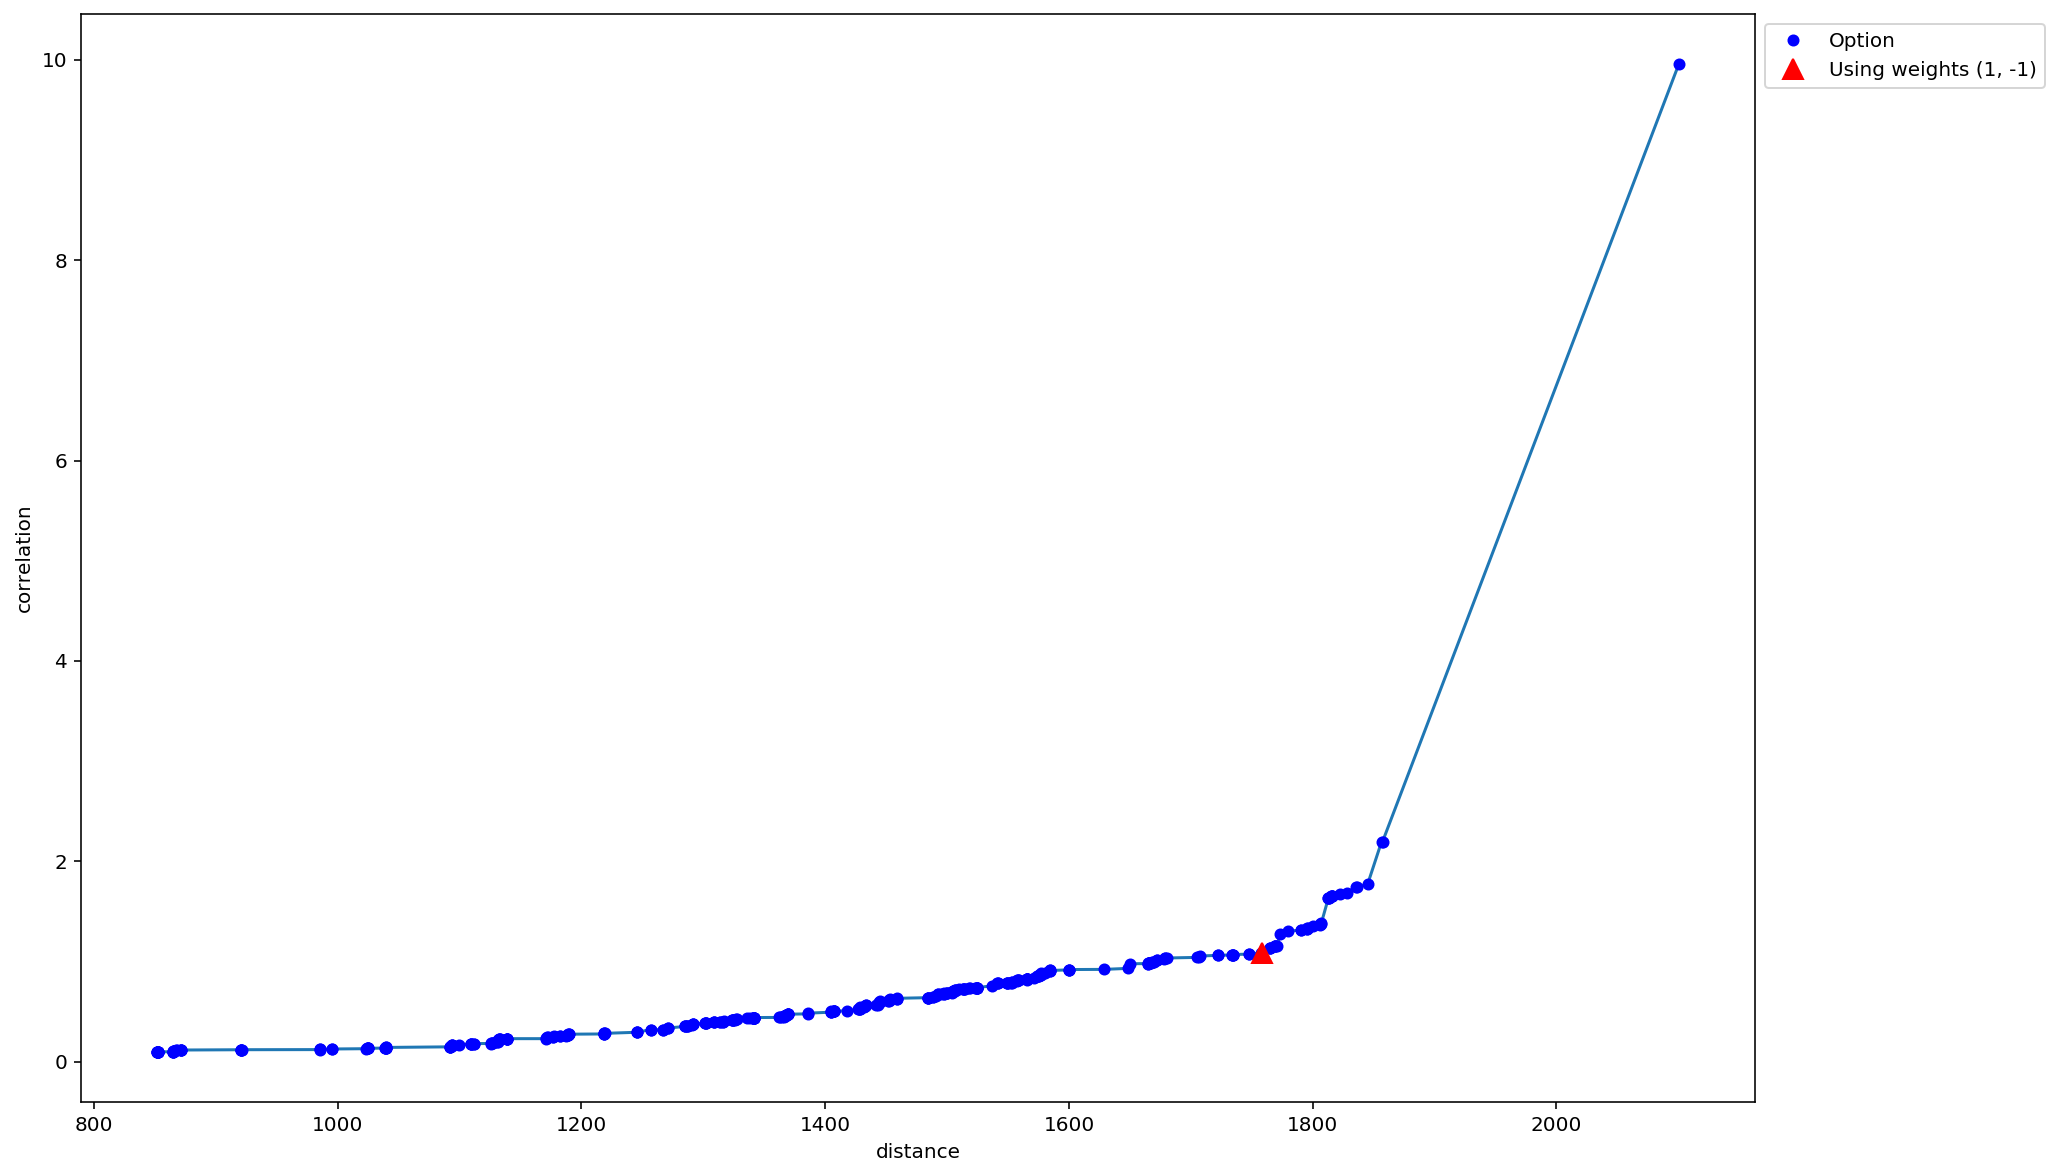

In [19]:
ag.plot(size='large',weights=(1,-1))

In [20]:
pareto = ag.pareto
len(pareto)

384

In [21]:
#select one solution from pareto front
centroids_sc_pareto = centroids_sc_hv[pareto[len(pareto)-1]] # the solution with min correlation
centroids_sc_pareto.shape

(400, 6)

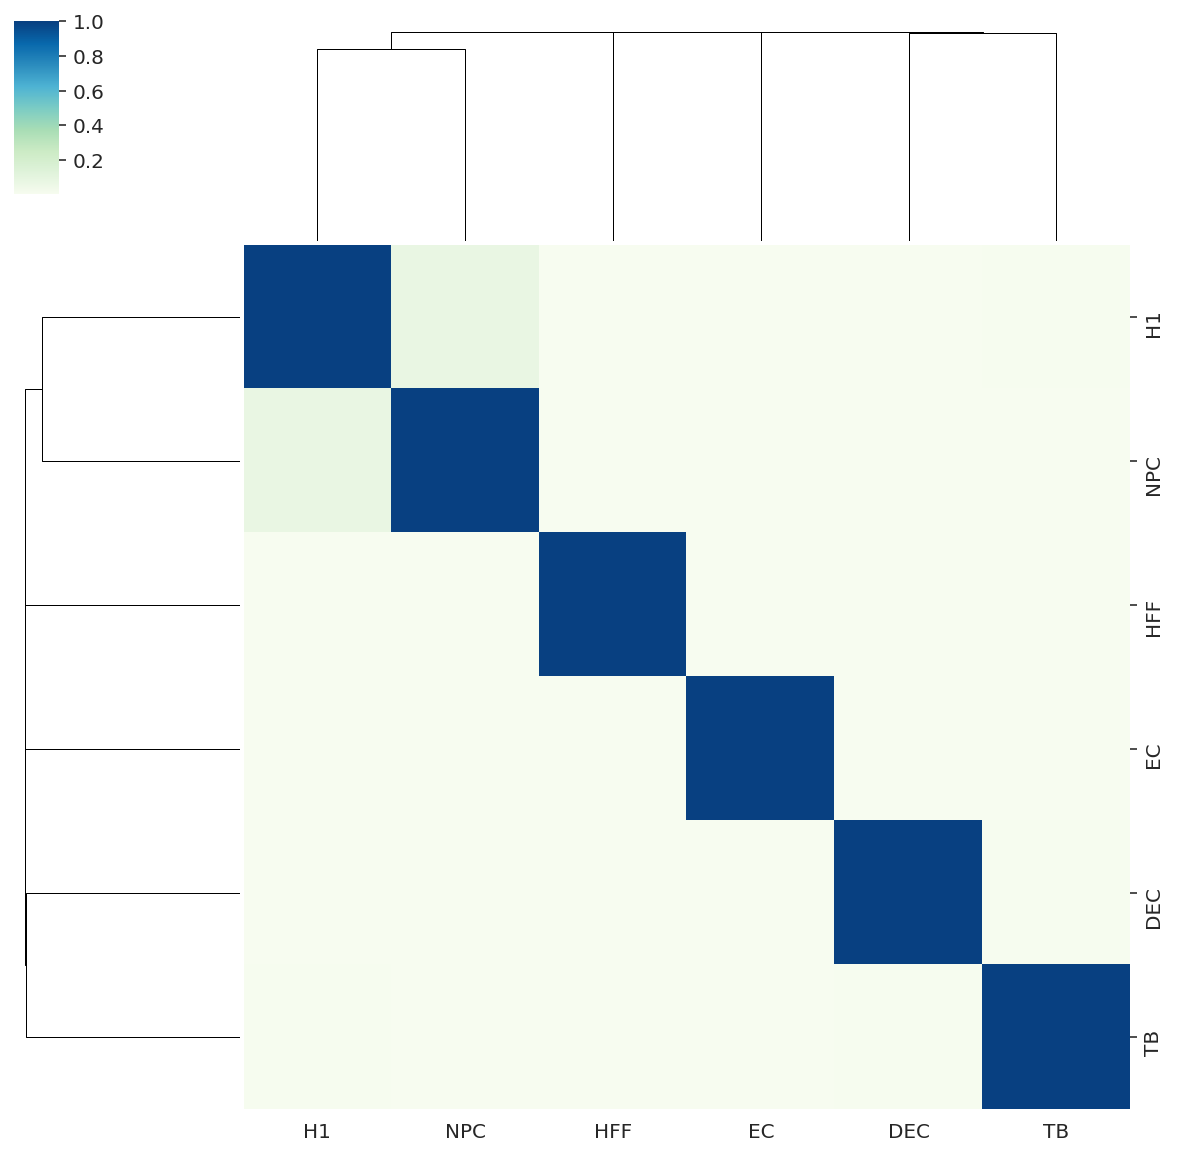

In [22]:
#Correlation matrix
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

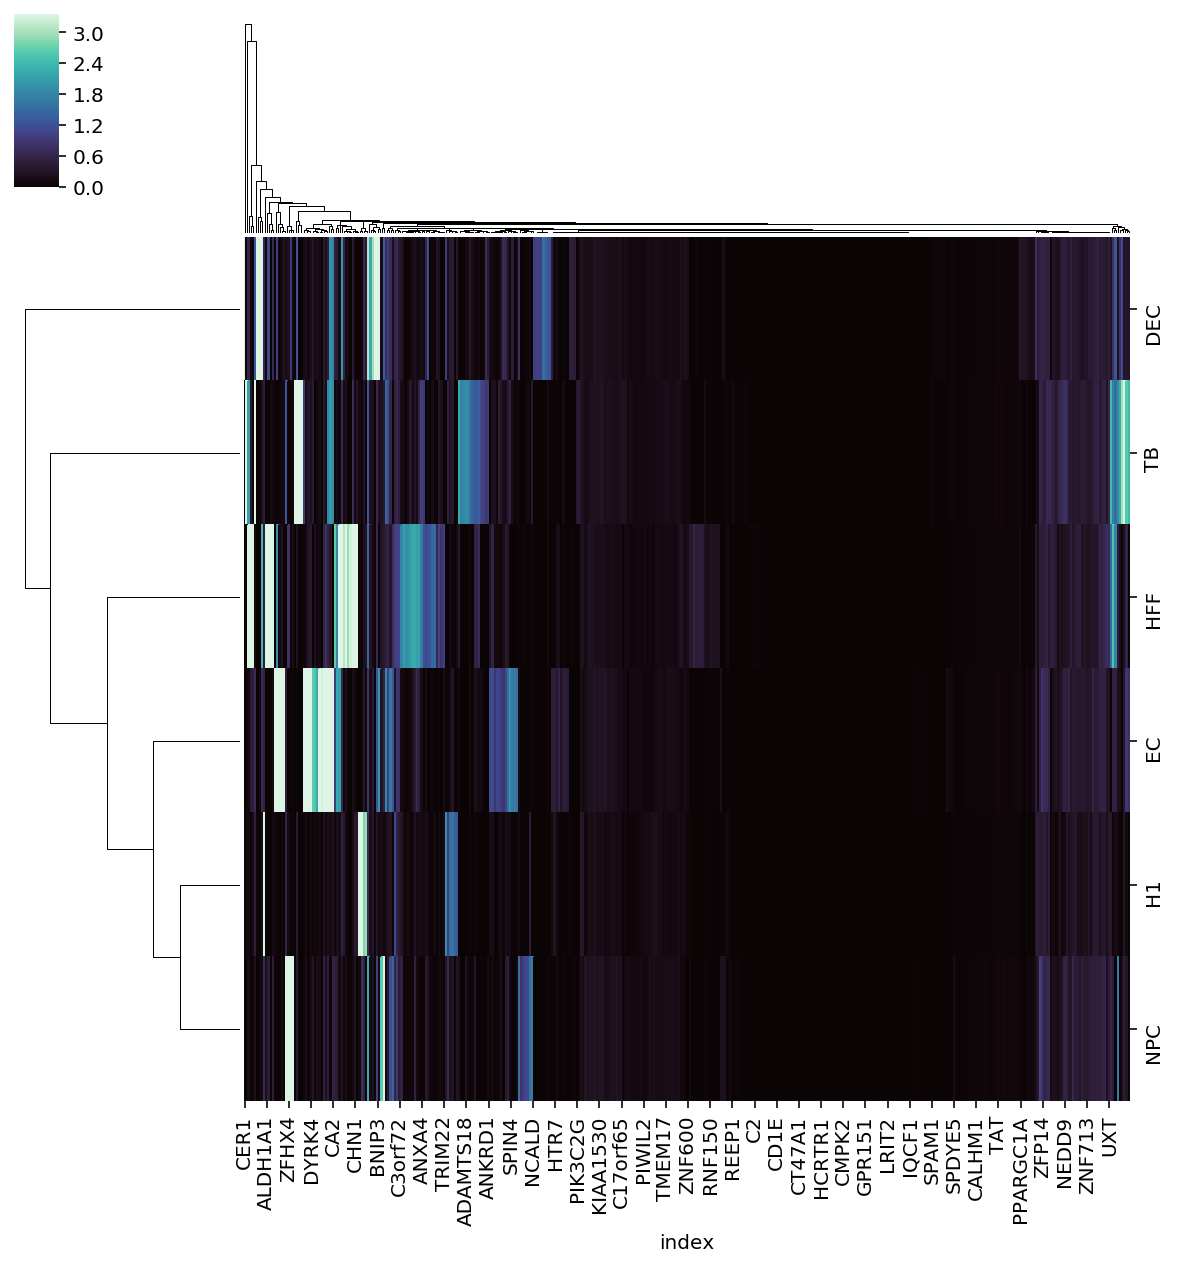

In [23]:
#marker genes
import seaborn as sns
subTypes = pd.DataFrame
subTypes = centroids_sc_pareto.columns
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique(), type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True)

# Linear Regression

In [24]:
#filter genes in the bulk samples
adata_bulk_proc = adata_bulk_raw[:,centroids_sc_pareto.index]

In [25]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
    return data_copy

In [26]:
#regression
means = []
for column in adata_bulk_proc.var.columns:
    if str('mean_') in str(column):
        means.append(column)
proportions_NuSVR = pd.DataFrame(columns=means)
proportions_nnls = pd.DataFrame(columns=means)


for column in adata_bulk_proc.var.columns:
    if str('bulk') in str(column):
        regr_NuSVR = NuSVR(nu=0.5,C=0.5,kernel='linear') #, nu=0.5
        regr_NuSVR.fit(centroids_sc_pareto, adata_bulk_proc.var[column])

        proportions_NuSVR.loc[column] = regr_NuSVR.coef_[0]
        proportions_nnls.loc[column] = sci.optimize.nnls(centroids_sc_pareto, adata_bulk_proc.var[column])[0]

proportions_NuSVR = proportions_NuSVR[proportions.columns]
proportions_nnls = proportions_nnls[proportions.columns]

proportions_NuSVR = normalize_proportions(proportions_NuSVR, copy = False)
proportions_nnls = normalize_proportions(proportions_nnls, copy = False)

In [27]:
def plot_(x,y,title):
    s,i,r,p,e = sci.stats.linregress(x,y)
    f = plt.figure(figsize=(5,5))
    ax = f.add_subplot(111)
    ax.scatter(x, y, color = 'black',s=5)
    
    x = np.linspace(np.min(x), np.max(x), 1000)
    y=x*s+i
    ax.plot(x,y)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    #ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.title(title)
    ax.text(0.8, 0.1,'p='+str(p), ha='center', va='center', transform=ax.transAxes)
    return

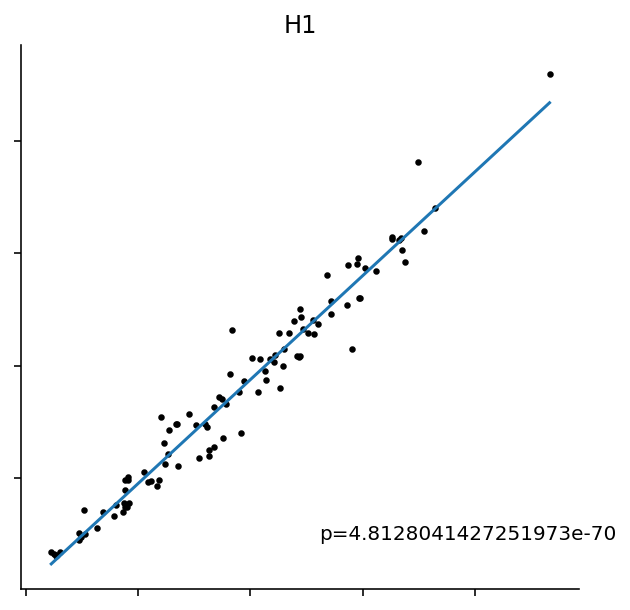

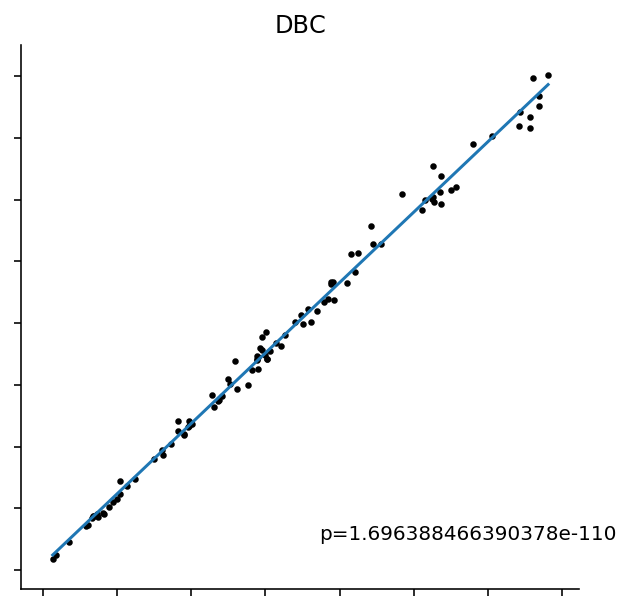

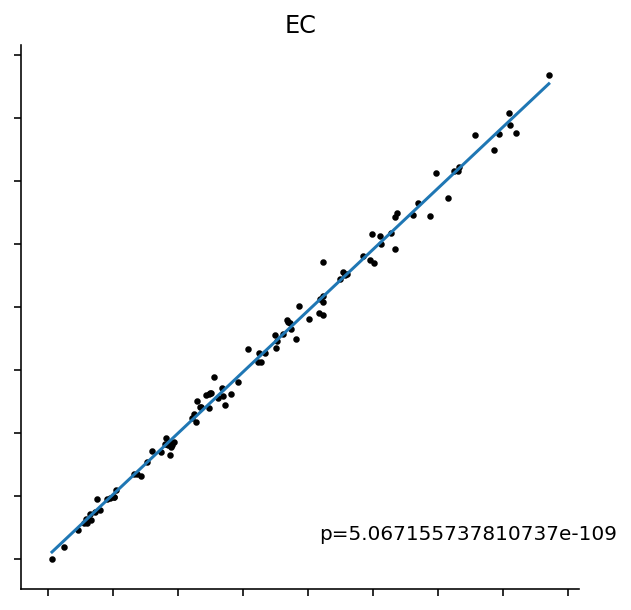

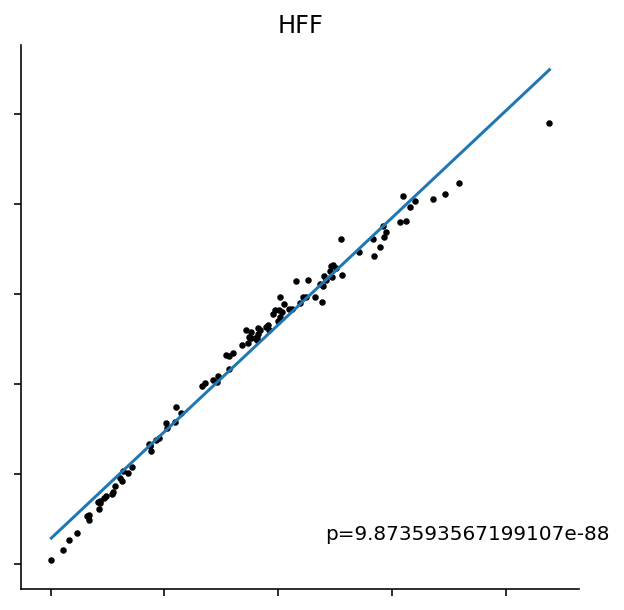

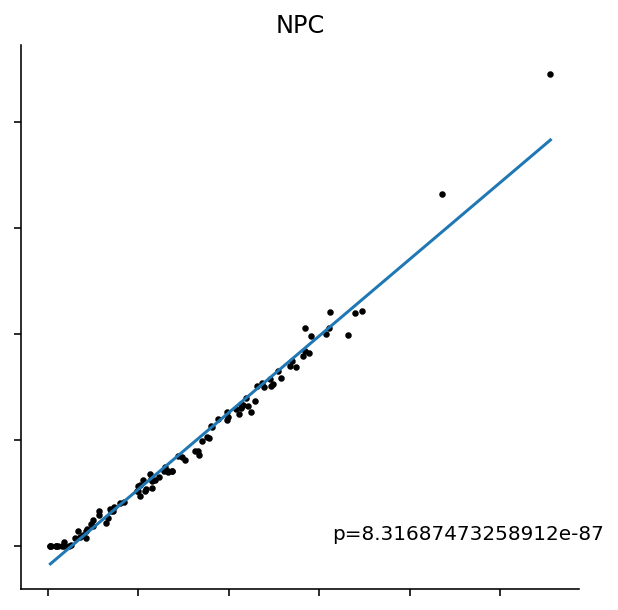

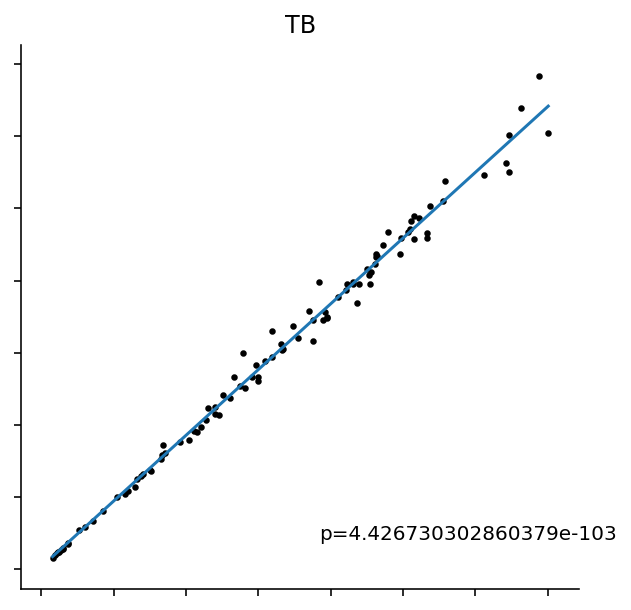

In [28]:
for c in proportions.columns:
    t = c
    plot_(proportions[c],proportions_NuSVR[c],t[5:])

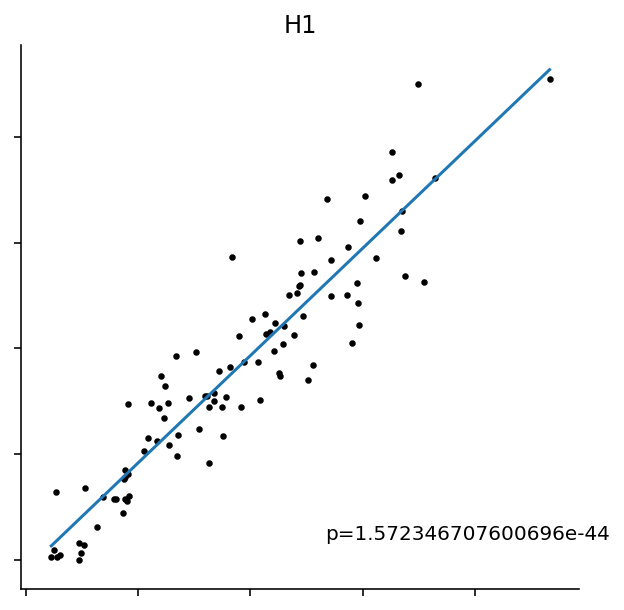

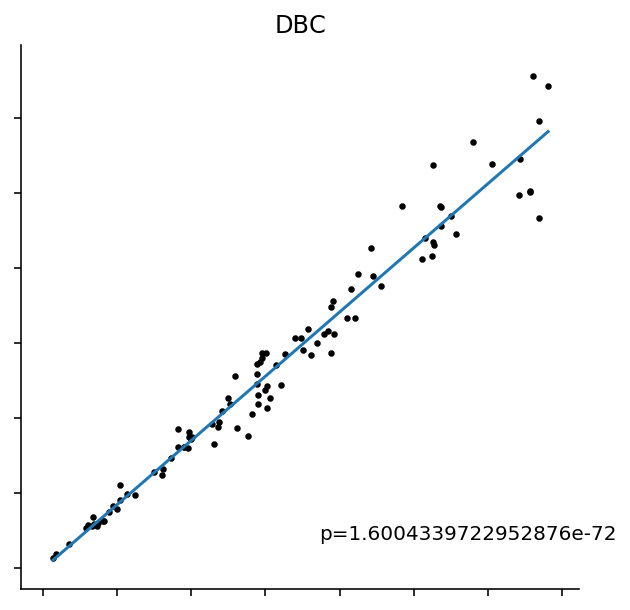

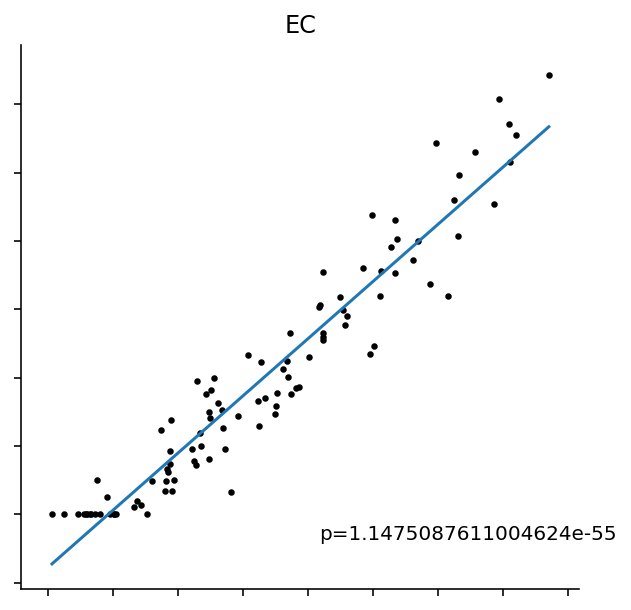

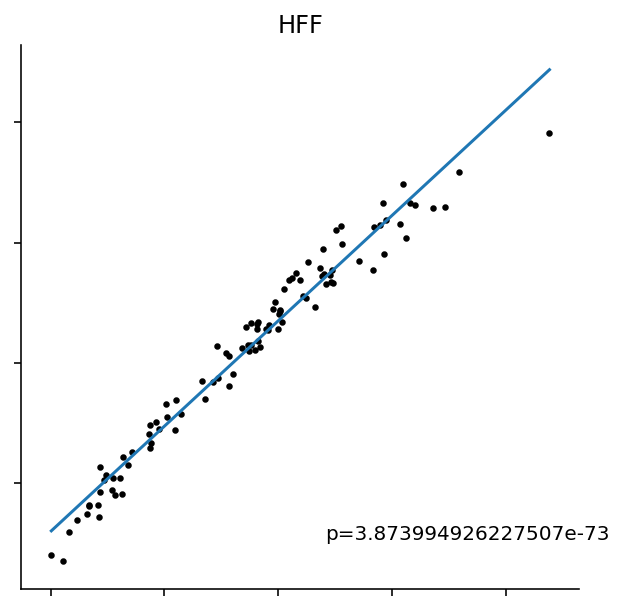

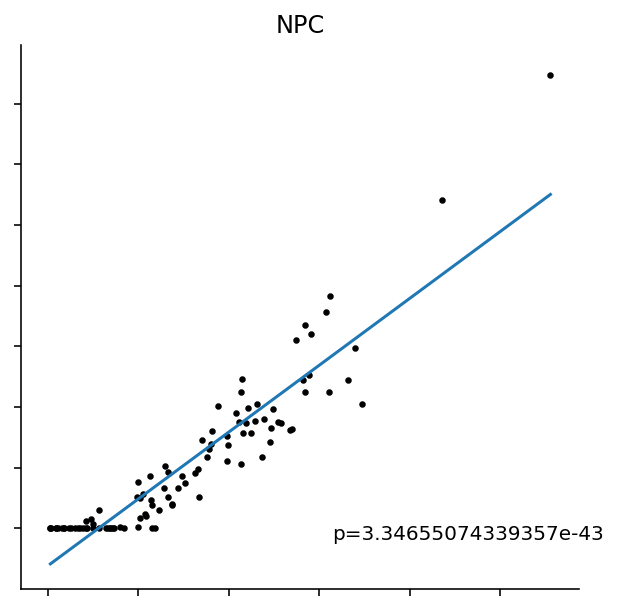

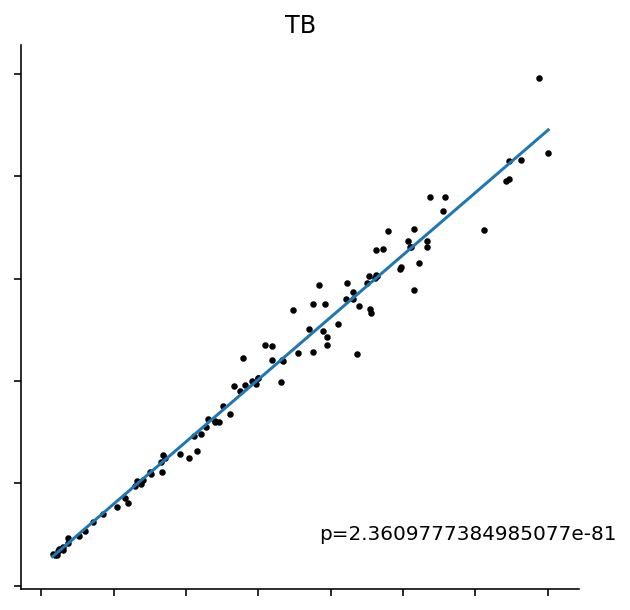

In [29]:
for c in proportions.columns:
    t = c
    plot_(proportions[c],proportions_nnls[c],t[5:])